# Spurious correlation.

In [2]:
# Generating artificial data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Initialize random number generator
np.random.seed(123)

# outcome parameter values
alpha, beta, sigma,  = 1.5, 3, 1
# spurse parameter values
alpha_spur, beta_spur, sigma_spur,  = 0.5, 1.2, 1.2
# Size of dataset
size = 100

# Predictor variable (first - true)
x = np.random.randn(size)
# Predictor variable (second - spurious)
x_spur = alpha_spur+ beta_spur*x + np.random.randn(size)*sigma_spur
# Simulate outcome variable
outcome = alpha + beta*x + np.random.randn(size)*sigma
df = pd.DataFrame(data={'x_true': x, 'x_spur': x_spur, 'outcome': outcome})
df.head()

x_true    x_spur   outcome
0 -1.085631 -0.032291 -1.053582
1  0.997345 -0.676651  3.893931
2  0.282978  1.694292  4.549638
3 -1.506295  1.810411 -2.330587
4 -0.578600 -0.223871 -0.242108

In [3]:
import pymc3 as pm
multivariate_model = pm.Model()
spurious_model = pm.Model()
with spurious_model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', alpha + beta * df.x_spur)
    
    outcome = pm.Normal('outcome', mu=mu, sd=sigma, observed=df.outcome)
    spurious_trace = pm.sample(1000, tune=1000)

with multivariate_model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', alpha + beta[0] * df.x_true + beta[1] * df.x_spur)
    
    outcome = pm.Normal('outcome', mu=mu, sd=sigma, observed=df.outcome)
    multi_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1238.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 784.83draws/s] 


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.formula.api as smf
from scipy import stats

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

/home/kacper/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/kacper/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


<p>Let's look for the dependence between outcome and x_spur in single variable model

Text(0, 0.5, 'outcome')

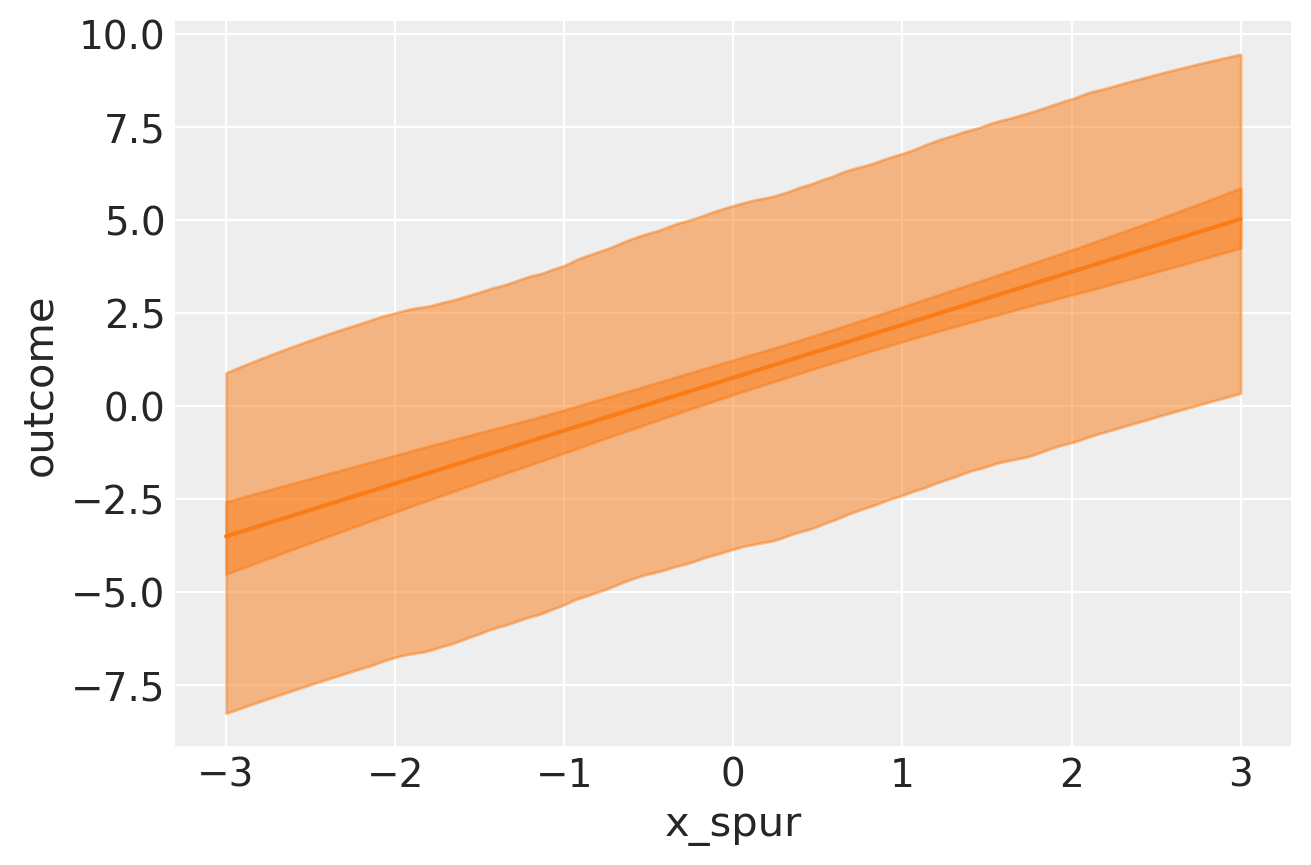

In [5]:
R_avg = np.linspace(-3, 3, 100)
mu_pred = spurious_trace['alpha'] + spurious_trace['beta'] * R_avg[:,None]
outcome_ = stats.norm.rvs(mu_pred, spurious_trace['sigma'])

plt.plot(R_avg, mu_pred.mean(1), 'C1')
az.plot_hpd(R_avg, mu_pred.T)
az.plot_hpd(R_avg, outcome_.T)

plt.xlabel('x_spur')
plt.ylabel('outcome')

Model with both variables

/home/kacper/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f699ec78710>,
      dtype=object)

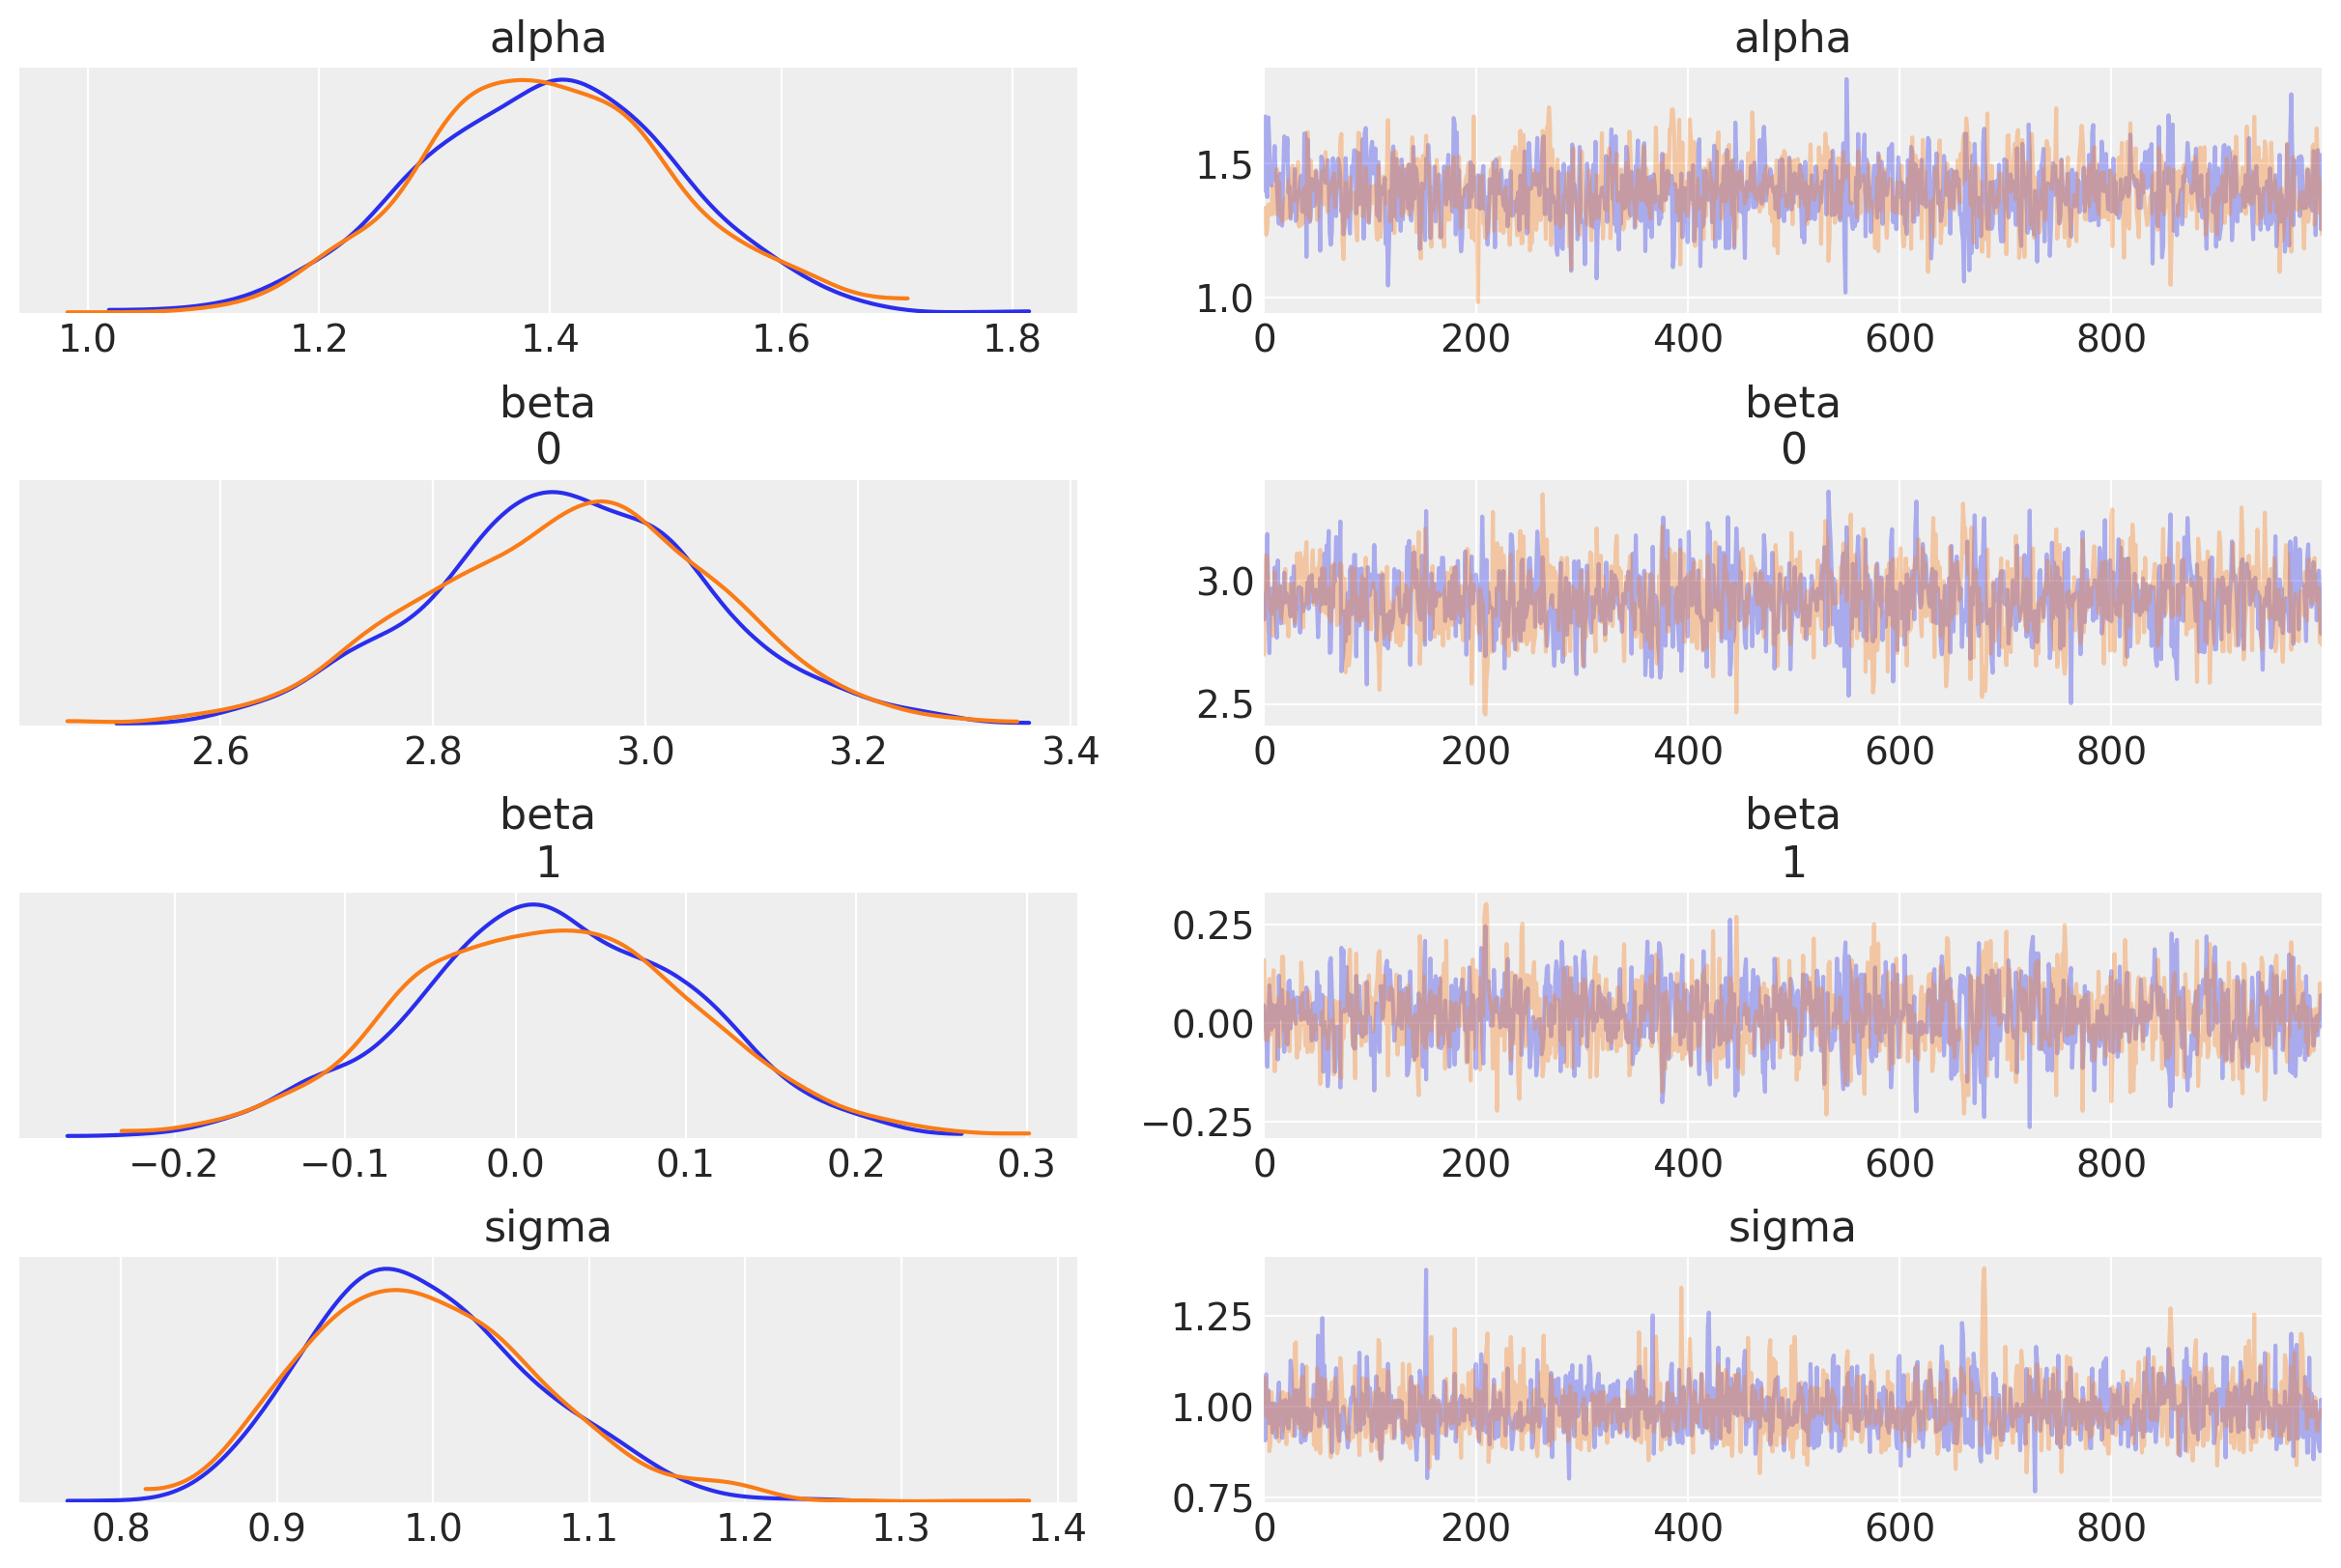

In [6]:
varnames = ['~mu']
az.plot_trace(multi_trace, varnames)

In [7]:
az.summary(multi_trace, varnames, credible_interval=.89)

/home/kacper/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


mean    sd  mc error  hpd 5.5%  hpd 94.5%     ess  r_hat
alpha    1.40  0.11       0.0      1.21       1.57  1517.0    1.0
beta[0]  2.93  0.13       0.0      2.71       3.14  1333.0    1.0
beta[1]  0.02  0.08       0.0     -0.13       0.14  1260.0    1.0
sigma    1.00  0.07       0.0      0.88       1.11  1594.0    1.0

Text(0, 0.5, 'outcome')

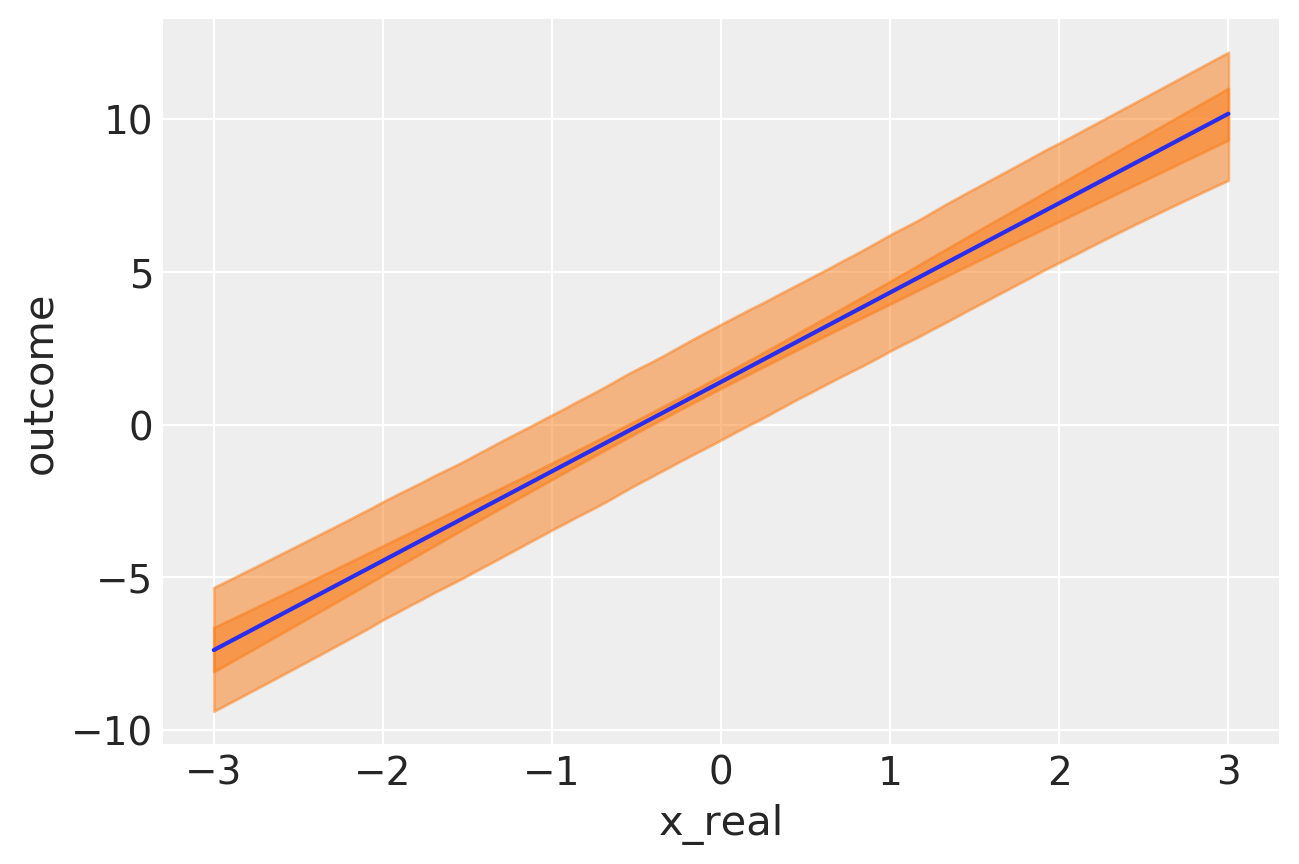

In [8]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = multi_trace['alpha'] + multi_trace['beta'][:,0] * R_avg[:,None]
outcome_ = stats.norm.rvs(mu_pred, multi_trace['sigma'])

plt.plot(R_avg, mu_pred.mean(1), 'C0')
az.plot_hpd(R_avg, mu_pred.T)
az.plot_hpd(R_avg, outcome_.T)

plt.xlabel('x_real')
plt.ylabel('outcome')


Text(0, 0.5, 'outcome')

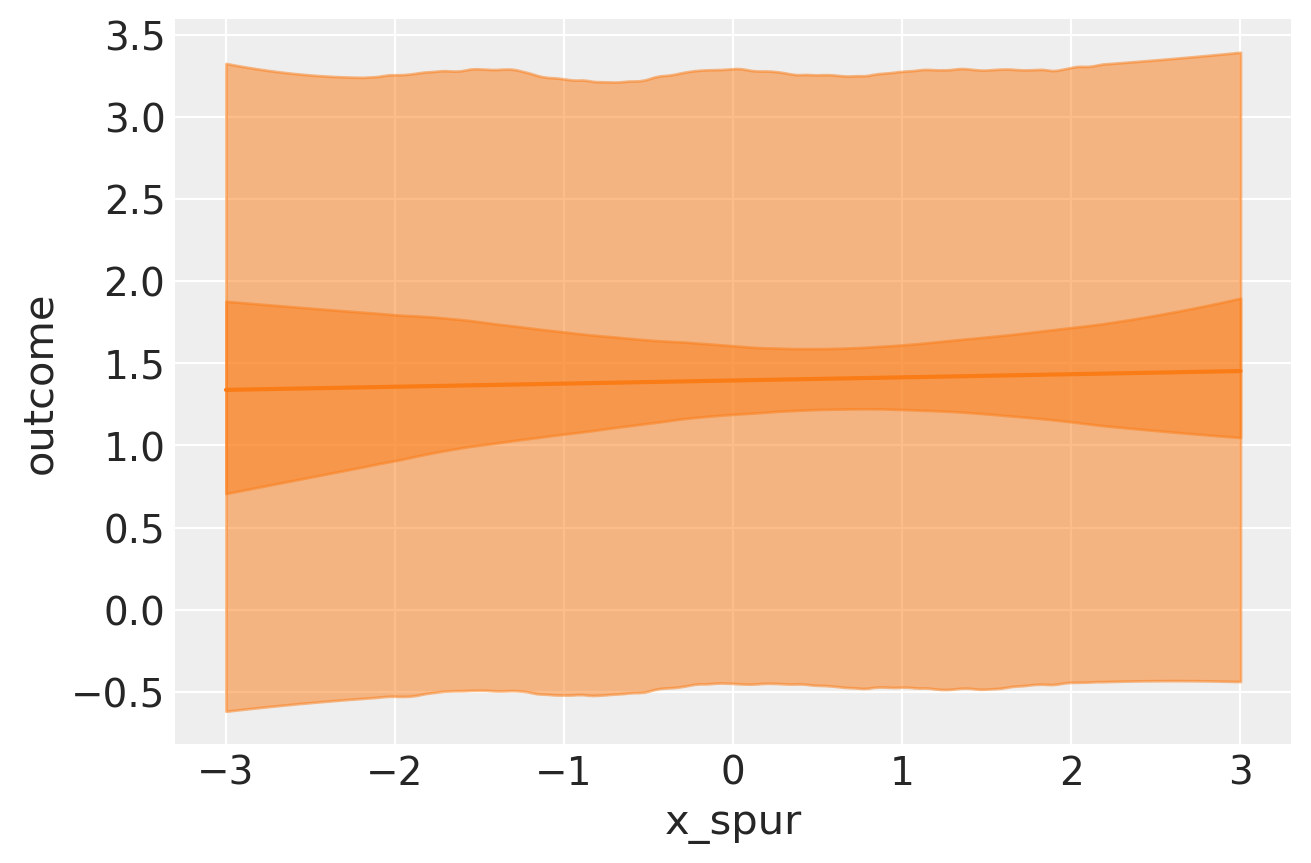

In [9]:
mu_pred = multi_trace['alpha'] + multi_trace['beta'][:,1] * R_avg[:,None]
outcome_ = stats.norm.rvs(mu_pred, multi_trace['sigma'])

plt.plot(R_avg, mu_pred.mean(1), 'C1')
az.plot_hpd(R_avg, mu_pred.T)
az.plot_hpd(R_avg, outcome_.T)

plt.xlabel('x_spur')
plt.ylabel('outcome')

We can see that the correlation between spurious data and outcome disappears.

# MASKED RELATIONSHIP

In [66]:
# Again I generate artificial data
# outcome parameter values
alpha_r, beta_r, sigma_r,  = 1.5, 3, 1
# negative
alpha_neg, beta_neg, sigma_neg = 0.4, 2.2, 1.3
# Size of dataset
size = 100

# Random data
x_pos = np.random.randn(size)
# Predictor variable (negative)
x_neg = alpha_neg + beta_neg*x_pos + np.random.randn(size)*sigma_neg
# Simulate outcome variable
outcome = alpha_r + beta_r*(x_pos - x_neg) + np.random.randn(size)*sigma_r
df = pd.DataFrame(data={'x_true': x, 'x_pos': x_pos,'x_neg': x_neg, 'outcome': outcome})
df.head()

x_true     x_pos     x_neg    outcome
0 -0.950654 -0.795270 -0.092741  -1.725204
1  0.442927 -1.119306 -3.361717   8.984230
2  1.513696 -1.500403 -4.153004  10.405069
3  1.132291 -0.983720 -2.458187   4.189977
4 -0.084606  0.645322  0.798718   0.806052

In [67]:
two_var_model = pm.Model()
pos_var = pm.Model()
neg_var = pm.Model()

with pos_var:
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta_pos', mu=0, sd=5, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', alpha + beta * df.x_pos)
    outcome = pm.Normal('outcome', mu=mu, sd=sigma, observed=df.outcome)
    pos_trace = pm.sample(1000, tune=1000)

with neg_var:
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta_neg', mu=0, sd=10, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', alpha + beta * df.x_neg)
    outcome = pm.Normal('outcome', mu=mu, sd=sigma, observed=df.outcome)
    neg_trace = pm.sample(1000, tune=1000)

with two_var_model:
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta_pos = pm.Normal('beta_pos', mu=0, sd=5, shape=1)
    beta_neg = pm.Normal('beta_neg', mu=0, sd=5, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', alpha + beta_pos * df.x_pos + beta_neg * df.x_neg)
    outcome = pm.Normal('outcome', mu=mu, sd=sigma, observed=df.outcome)
    both_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_pos, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1328.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_neg, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1198.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_neg, beta_pos, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 685.57draws/s]


(<Figure size 1500x1000 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f699c4bad68>],
       dtype=object))

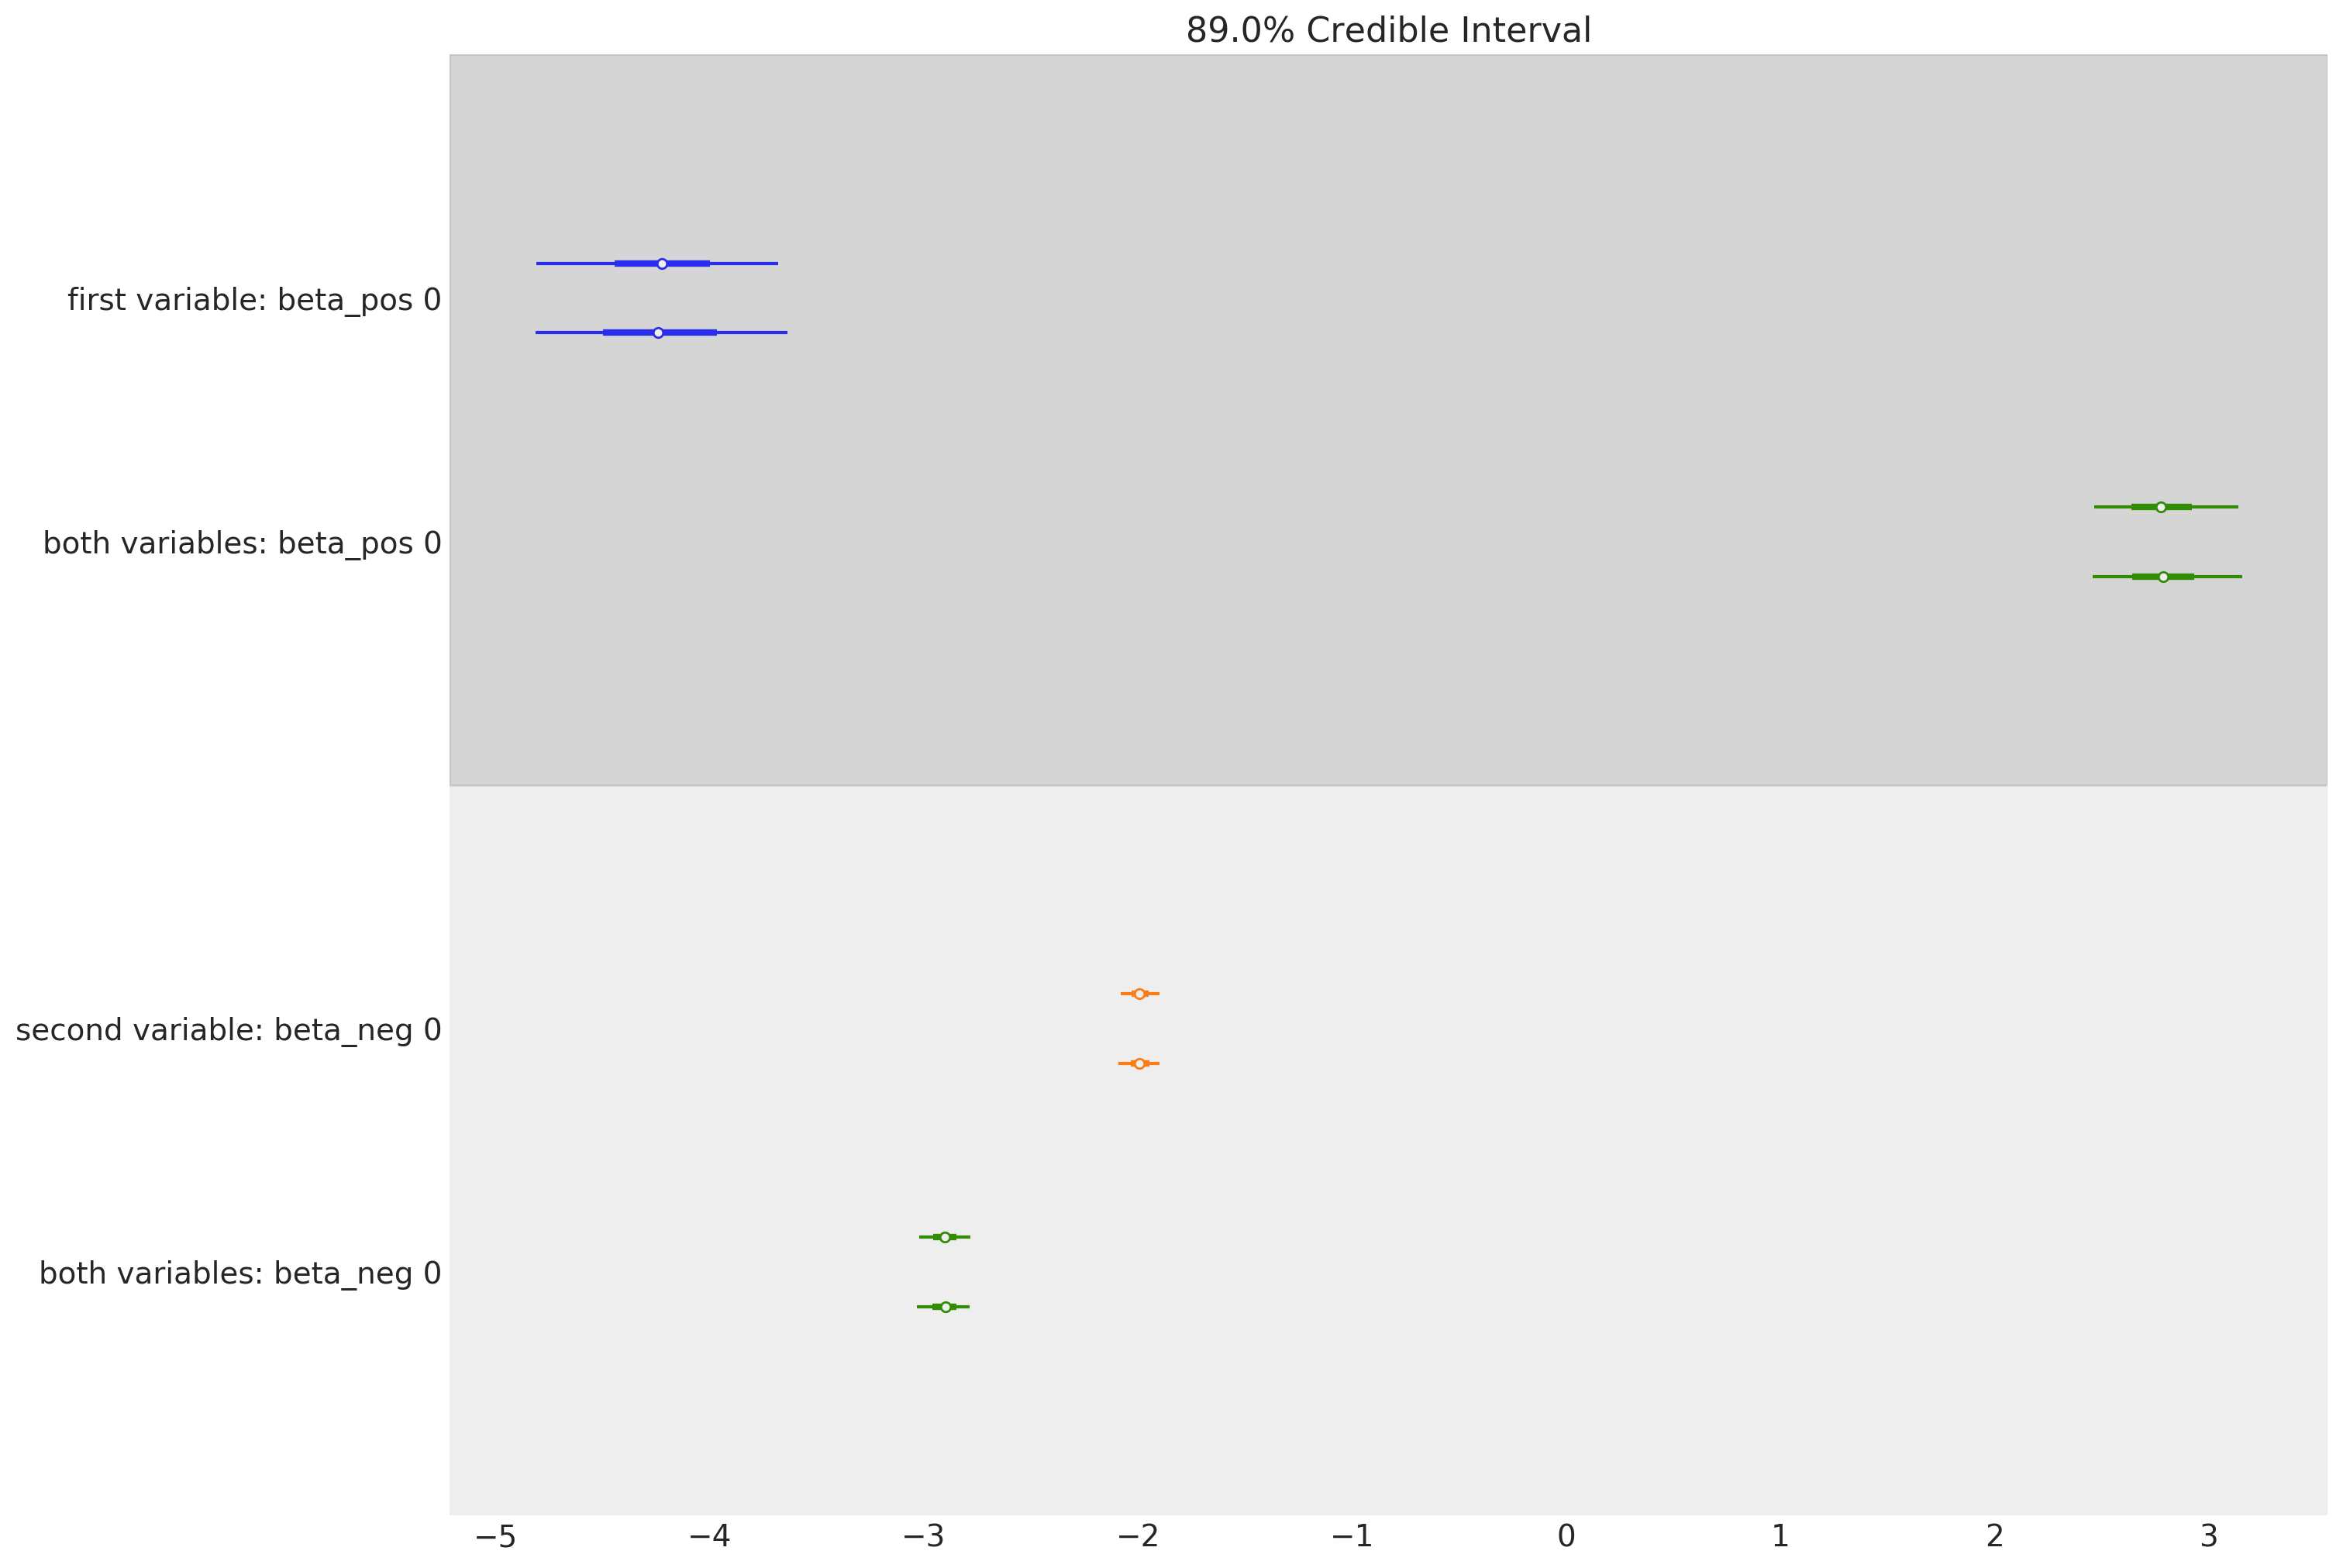

In [69]:
varnames = ['~mu', '~alpha', '~sigma']
models = [pos_trace, neg_trace, both_trace]
model_names = ['first variable', 'second variable', 'both variables']
az.plot_forest(models, model_names=model_names, var_names=varnames, credible_interval=0.89, figsize=(15,10))

We can see, that the both variables are masked, if we create a model for each variable separately we will get different results than if we used both (two variable model). As shown in the graph above, means with credible intervals are shifted for predictor variables.